In [17]:
import glob
import os
import os.path as osp
import random
import json
import time
import hashlib

import torch
import torch.nn as nn
import torchvision as tv
from torchvision import transforms as T
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import ExifTags, Image, ImageOps, ImageFile
import numpy as np

# Parameters
IMG_FORMATS = ["bmp", "jpg", "jpeg", "png", "tif", "tiff", "dng", "webp", "mpo"]
# Get orientation exif tag
for k, v in ExifTags.TAGS.items():
    if v == "Orientation":
        ORIENTATION = k
        break


In [18]:
def check_image(im_file):
    # verify an image.
    nc, msg = 0, ""
    try:
        im = Image.open(im_file)
        plt.imshow(im)
        im.verify()  # PIL verify

        shape = im.size  # (width, height)
        im_exif = im._getexif()
        if im_exif and ORIENTATION in im_exif:
            rotation = im_exif[ORIENTATION]
            if rotation in (6, 8):
                shape = (shape[1], shape[0])

        assert (shape[0] > 9) & (shape[1] > 9), f"image size {shape} <10 pixels"
        assert im.format.lower() in IMG_FORMATS, f"invalid image format {im.format}"
        if im.format.lower() in ("jpg", "jpeg"):
            with open(im_file, "rb") as f:
                f.seek(-2, 2)
                if f.read() != b"\xff\xd9":  # corrupt JPEG
                    ImageOps.exif_transpose(Image.open(im_file)).save(
                        im_file, "JPEG", subsampling=0, quality=100
                    )
                    msg += f"WARNING: {im_file}: corrupt JPEG restored and saved"
        return im_file, shape, nc, msg
    except Exception as e:
        nc = 1
        msg = f"WARNING: {im_file}: ignoring corrupt image: {e}"
        return im_file, None, nc, msg

In [2]:
%cd ..

/home/pill/competition/yolov7


torch.Size([4000, 3000, 3])
tensor([[1280.6667, 1626.0000,  598.6667,  364.5000],
        [2180.0000, 1736.6250,  442.6667,  281.2500],
        [2401.3333, 2043.3750,  442.6667,  267.7500],
        [1359.3333, 1919.2500, 1001.3334,  415.5000],
        [1760.0000, 2121.7500,  949.3333,  498.0000]])


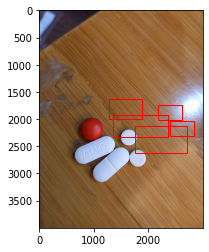

In [19]:
def visual2(img, boxes=None, isTrain=True):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  if boxes is not None:
    if len(boxes.shape) == 1:
      boxes = boxes[None, :]
    for box in boxes:
      x_min, y_min, w, h = box[0], box[1], box[2], box[3]
      rect = matplotlib.patches.Rectangle((x_min, y_min), w, h, color='r', fc='none')
      ax.add_patch(rect)
  plt.imshow(img)

file = 'VAIPE_P_45_17'

img = torch.tensor(mpimg.imread('./vaipe_exif/train/images/' + file + '.jpg'))
print(img.size())
width, height = img.size()[0], img.size()[1]
boxes = []
with open('./vaipe_exif/train/labels/' + file + '.txt') as file_in:
  for line in file_in:
    label, x_min, y_min, w, h = line.split(' ')
    x_min, y_min, w, h = float(x_min), float(y_min), float(w), float(h)
    boxes.append([x_min, y_min, w, h])

boxes = torch.tensor(boxes)

#get bbox
boxes = boxes * torch.tensor([width, height, width, height])
print(boxes)
visual2(img, boxes)

In [13]:
img_file = './vaipe_exif/train/images/VAIPE_P_45_17.jpg'
with open(img_file, "rb") as f:
    f.seek(-2, 2)
    if f.read() != b"\xff\xd9":  # corrupt JPEG
        ImageOps.exif_transpose(Image.open(img_file)).save(
            img_file, "JPEG", subsampling=0, quality=100
        )

In [21]:

with open(img_file, "rb") as f:
    f.seek(-2, 2)
    if f.read() != b"\xff\xd9":  # corrupt JPEG
        ImageOps.exif_transpose(Image.open(img_file)).save(
            img_file, "JPEG", subsampling=0, quality=100
        )

img = Image.open(img_file)
plt.imshow(img)
